In [1]:
# Toutes les bibliothèques et fonctions utilisées
import os
import gensim # pip install gensim
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk # pip install nltk
from nltk.corpus import stopwords
stop = stopwords.words('french')

from nltk.stem import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer
import collections
from collections import Counter

from wordcloud import WordCloud

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
import scikitplot.plotters as skplt # pip install scikit-plot
from sklearn import preprocessing

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, \
    GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam

# Pour empêcher l'affichage de messages d'erreurs en Python
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

Using TensorFlow backend.


In [5]:
# ouverture du fichier csv avec le séprateur ;
data=pd.read_csv('act_couv.csv',sep=";")

In [6]:
# la taille des données chargées 6663 documents (lignes) et 2 colonnes dont l'une represente le corpus et l'autre la classe
data.shape 
data.head()

,description,class
0,entreprises de menuiserie fabricant de porte p...,False
1,cheminees accessoires specialiste du fer forg...,False
2,bricolage outillage reproduction de cle robin...,False
3,vente pose de revetements de sols et de murs ...,False
4,vente installation de chauffage vente inst...,True


# Analyses preliminaires

### Répartition des classes de la variable cible

False    5705
True      958
Name: class, dtype: int64

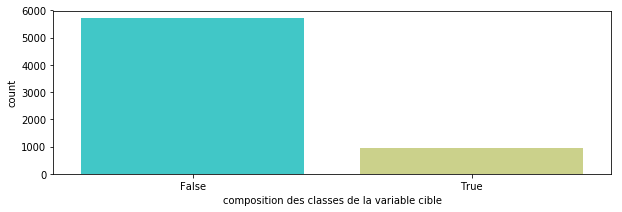

In [43]:
#Répartition des classes de la variable cible
plt.figure(figsize=(10,3))
sns.countplot(data['class'],palette='rainbow')
plt.xlabel('composition des classes de la variable cible')
data['class'].value_counts()

In [45]:
#Regardons la distribution de la variable cible
print("Mean: %f" % data['class'].mean())
print("Std: %f" % data['class'].std())
print("Median: %f" % data['class'].median())
print("Skewness: %f" % data['class'].skew())
print("Kurtosis: %f" % data['class'].kurt())

Mean: 0.143779
Std: 0.350892
Median: 0.000000
Skewness: 2.030984
Kurtosis: 2.125533


**La variable classe est très déséquilibré ce qui a overfitter un peu les modèles avec un Accuracy élévé !!**

### nombre de mot dans chaque document

In [7]:
data['word_count'] = data['description'].apply(lambda x: len(str(x).split(" ")))
data[['description','word_count']].head()

,description,word_count
0,entreprises de menuiserie fabricant de porte p...,38
1,cheminees accessoires specialiste du fer forg...,150
2,bricolage outillage reproduction de cle robin...,86
3,vente pose de revetements de sols et de murs ...,109
4,vente installation de chauffage vente inst...,19


## nombre de caratères dans chaque document

In [8]:
data['char_count'] = data['description'].str.len() ## Ceci inclut également les espaces
data[['description','char_count']].head()

,description,char_count
0,entreprises de menuiserie fabricant de porte p...,232
1,cheminees accessoires specialiste du fer forg...,1005
2,bricolage outillage reproduction de cle robin...,653
3,vente pose de revetements de sols et de murs ...,651
4,vente installation de chauffage vente inst...,121


### nombre moyen de mots dans chaque document

In [9]:
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

In [10]:
data['avg_word'] = data['description'].apply(lambda x: avg_word(x))
data[['description','avg_word']].head()

,description,avg_word
0,entreprises de menuiserie fabricant de porte p...,5.571429
1,cheminees accessoires specialiste du fer forg...,6.028169
2,bricolage outillage reproduction de cle robin...,6.926829
3,vente pose de revetements de sols et de murs ...,5.376238
4,vente installation de chauffage vente inst...,7.357143


### Le nombre de stop_words = mots non significatifs pour l'analyse 

In [11]:
data['stopwords'] = data['description'].apply(lambda x: len([x for x in x.split() if x in stop]))
data[['description','stopwords']].head()

,description,stopwords
0,entreprises de menuiserie fabricant de porte p...,10
1,cheminees accessoires specialiste du fer forg...,45
2,bricolage outillage reproduction de cle robin...,8
3,vente pose de revetements de sols et de murs ...,32
4,vente installation de chauffage vente inst...,4


### le nombre de caractères numériques dans chaque dictionnaire

In [12]:
data['numerics'] = data['description'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
data[['description','numerics']].head()

,description,numerics
0,entreprises de menuiserie fabricant de porte p...,0
1,cheminees accessoires specialiste du fer forg...,0
2,bricolage outillage reproduction de cle robin...,0
3,vente pose de revetements de sols et de murs ...,1
4,vente installation de chauffage vente inst...,0


### le nombre de lettres en majuscule dans chaque document

In [13]:
data['upper'] = data['description'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
data[['description','upper']].head()

,description,upper
0,entreprises de menuiserie fabricant de porte p...,0
1,cheminees accessoires specialiste du fer forg...,0
2,bricolage outillage reproduction de cle robin...,0
3,vente pose de revetements de sols et de murs ...,0
4,vente installation de chauffage vente inst...,0


In [14]:
# Aucun mot en majuscule
data[['description','upper']].describe(include='all')

,description,upper
count,6663,6663.0
unique,3341,NaN
top,entreprises d electricite generale,NaN
freq,566,NaN
mean,NaN,0.0
std,NaN,0.0
min,NaN,0.0
25%,NaN,0.0
50%,NaN,0.0
75%,NaN,0.0


# Pretraitement des données

###  Suppression des ponctuations et caractères spéciales (vides inclus, ...)

In [15]:
train = data.copy()

In [16]:
data['description'][5]

'rideaux  voilages  tissus d ameublement vente de stores d interieur et d exterieur vente de volets roulants vente d ameublement d interieur installation de stores reparation de stores entoilage de stores motorisation de stores marques dickson produits stores volets roulants parasols geants pieds decales mobilier de jardin portails et portes de garage articles de menuiserie  rideaux  voilages  tissus d ameublement tapissiers decorateurs nous vous proposons la vente et l installation d une large gamme de stores et de volets roulants  adaptes a vos besoins et a votre budget nous effectuons la reparation  l entoilage  la motorisation de stores existants  avec un travail de qualite nous vous presentons egalement un large choix de parasols geants  de pieds decales  ainsi que des coussins de jardin  des equipements pour les bateaux et plusieurs articles d ameublement d interieur pour plus d informations  n hesitez pas a consulter notre site  '

In [17]:
train['description'] = train['description'].str.replace('[^\w\s]','')
train['description'][5]

'rideaux  voilages  tissus d ameublement vente de stores d interieur et d exterieur vente de volets roulants vente d ameublement d interieur installation de stores reparation de stores entoilage de stores motorisation de stores marques dickson produits stores volets roulants parasols geants pieds decales mobilier de jardin portails et portes de garage articles de menuiserie  rideaux  voilages  tissus d ameublement tapissiers decorateurs nous vous proposons la vente et l installation d une large gamme de stores et de volets roulants  adaptes a vos besoins et a votre budget nous effectuons la reparation  l entoilage  la motorisation de stores existants  avec un travail de qualite nous vous presentons egalement un large choix de parasols geants  de pieds decales  ainsi que des coussins de jardin  des equipements pour les bateaux et plusieurs articles d ameublement d interieur pour plus d informations  n hesitez pas a consulter notre site  '

### Suppression des stop_words en Français

In [18]:
from nltk.corpus import stopwords
stop = stopwords.words('french')

In [19]:
train['description'] = train['description'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
train['description'][4]

'vente installation chauffage vente installation chauffage installation sanitaires entreprises couverture'

In [20]:
data['description'][4]

'vente  installation de chauffage   vente  installation de chauffage installation de sanitaires entreprises de couverture '


**Nous rajoutons également une liste de stop_word français qu'on éliminera du corpus dans le cas où certains mots n'ont pas 
été considéré dans les 1er pretraitement qu'on avait faite avant!!**


In [21]:
# https://www.ranks.nl/stopwords/french
STOP = set(['alors','au','aucun','aussi','autre','avant','avec','avoir','bon','car','ce','cela','ces',
            'ceux','chaque','ci','comme','comment','dans','des','du','dedans','dehors',
            'depuis','devrait','doit','donc','dos','début','elle','elles','en','encore','essai'
            'est','et','eu','fait','faites','fois','font','hors','ici','il',
            'ils','je','juste','la','le','les','leur','là','ma','maintenant','mais',
            'mes','mine','moins','mon','mot','même','ni','nommés','notre','nous','ou','où','par','parce','pas',
            'peut','peu','plupart','pour','pourquoi','quand','que','quel','quelle','quelles','quels',
            'qui','sa','sans','ses','seulement','si','sien','son','sont','sous','soyez','sujet',
            'sur','ta','tandis','tellement','tels','tes','ton','tous','tout','trop','très''tu',
            'voient','vont','votre','vous','vu','ça','étaient','étions','été','être'])

In [22]:

train['description'] = train['description'].apply(lambda x: " ".join(x for x in x.split() if x not in STOP))
train['description'][4]

'vente installation chauffage vente installation chauffage installation sanitaires entreprises couverture'

### Suppression des mots trop commun/répétitifs

In [23]:
freq = pd.Series(' '.join(train['description']).split()).value_counts()[:10]
freq

entreprises     4899
a               3234
installation    3224
travaux         2411
pose            2364
menuiserie      2098
vente           2071
produits        1840
renovation      1667
electricite     1636
dtype: int64

In [24]:
# ces mots sont beaucoup trop repetitifs surtout "entreprises"

In [25]:
freq = list(freq.index)
train['description'] = train['description'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
train['description'][4]

'chauffage chauffage sanitaires couverture'

In [26]:
data['description'][4]

'vente  installation de chauffage   vente  installation de chauffage installation de sanitaires entreprises de couverture '


### Suppression des mots rarement utilisés également !

In [27]:
freq = pd.Series(' '.join(train['description']).split()).value_counts()[-10:]
freq

operez           1
exclusif         1
atmospherique    1
opter            1
class            1
idem             1
4411             1
autoportant      1
pep              1
forcement        1
dtype: int64

In [28]:
freq = list(freq.index)
train['description'] = train['description'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
train['description'].head()

0    fabricant porte portail aluminium porte entree...
1    cheminees accessoires specialiste fer forge de...
2    bricolage outillage reproduction cle robinette...
3    revetements sols murs entreprise peinture deco...
4            chauffage chauffage sanitaires couverture
Name: description, dtype: object

### Stemmization : on ne garde les racines de chaque mots

In [29]:
from nltk.stem import SnowballStemmer
ss = SnowballStemmer("french")
train['description'].apply(lambda x: " ".join([ss.stem(word) for word in x.split()]))

0       fabric port portail aluminium port entre port ...
1       chemine accessoir special fer forg deplac chan...
2       bricolag outillag reproduct cle robinetter acc...
3       revet sol mur entrepris peintur decor conseil ...
4                    chauffag chauffag sanitair couvertur
5       rideau voilag tissus ameubl stor interieur ext...
6       couvertur couvertur zinguer tubag chemine ante...
7                                                chauffag
8       plombi chauffag chauffag plomber contrat entre...
9       pomp funebr marbrer fleurist contrat prevoi ob...
10      carrelag dallag carrelag faienc mosaiqu sall e...
11                                                general
12      stor depannag menuiser exterieur depannag port...
13                      peintur peintur sol peintur volet
14      construct metall serrurer metaller robotis bur...
15                                               maconner
16      plombi contrat entretien chaudier pomp chaleur...
17      magasi

In [34]:
data['description'][5]

'rideaux  voilages  tissus d ameublement vente de stores d interieur et d exterieur vente de volets roulants vente d ameublement d interieur installation de stores reparation de stores entoilage de stores motorisation de stores marques dickson produits stores volets roulants parasols geants pieds decales mobilier de jardin portails et portes de garage articles de menuiserie  rideaux  voilages  tissus d ameublement tapissiers decorateurs nous vous proposons la vente et l installation d une large gamme de stores et de volets roulants  adaptes a vos besoins et a votre budget nous effectuons la reparation  l entoilage  la motorisation de stores existants  avec un travail de qualite nous vous presentons egalement un large choix de parasols geants  de pieds decales  ainsi que des coussins de jardin  des equipements pour les bateaux et plusieurs articles d ameublement d interieur pour plus d informations  n hesitez pas a consulter notre site  '

In [35]:
train['description'][5]

'rideaux voilages tissus ameublement stores interieur exterieur volets roulants ameublement interieur stores reparation stores entoilage stores motorisation stores marques dickson stores volets roulants parasols geants pieds decales mobilier jardin portails portes garage articles rideaux voilages tissus ameublement tapissiers decorateurs proposons large gamme stores volets roulants adaptes besoins budget effectuons reparation entoilage motorisation stores existants travail qualite presentons egalement large choix parasols geants pieds decales ainsi coussins jardin equipements bateaux plusieurs articles ameublement interieur plus informations hesitez consulter site'

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
import collections
from collections import Counter

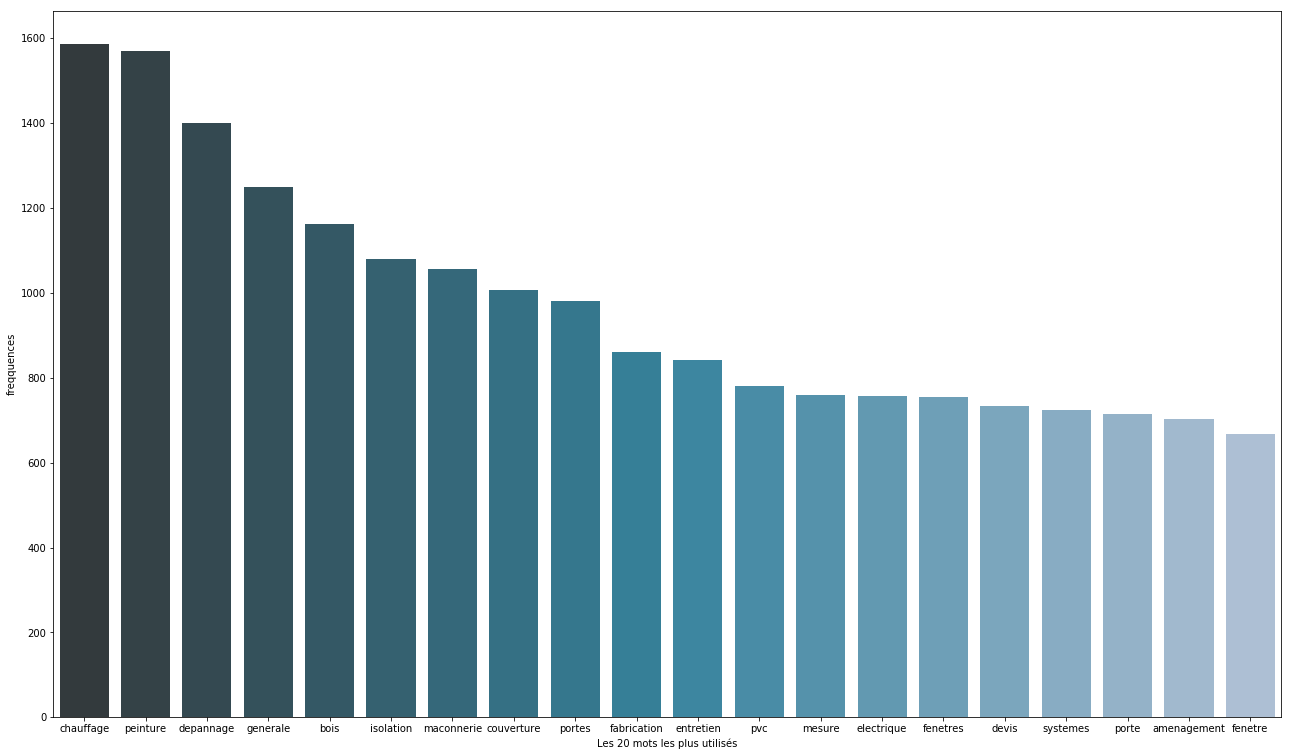

In [37]:
cv = CountVectorizer()
bow = cv.fit_transform(train.description)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ["Les 20 mots les plus utilisés", "freqquences"])

fig, ax = plt.subplots(figsize=(22, 13))
sns.barplot(x="Les 20 mots les plus utilisés", y="freqquences", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

**on voit que le mot couverture fait partie des 20 mots les plus utilisés dans le corpus contenant l'ensemble des documents**

**Regardons de près si le mot 'couverture' est effectivement plus lié à la classe positive tel qu'indiqué dans l'énoncé du test!**

In [38]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
# données pour la classe positive
train_pos = train[ train['class'] == True]
train_pos = train_pos['description']

# données pour la classe négative
train_neg = train[ train['description'] == False]
train_neg = train_neg['description']

# On crée une petite fonction que l'on customise avec les paramètres d'affichage de notre choix
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    wordcloud = WordCloud(stopwords=STOP,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(words)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()


Positive words


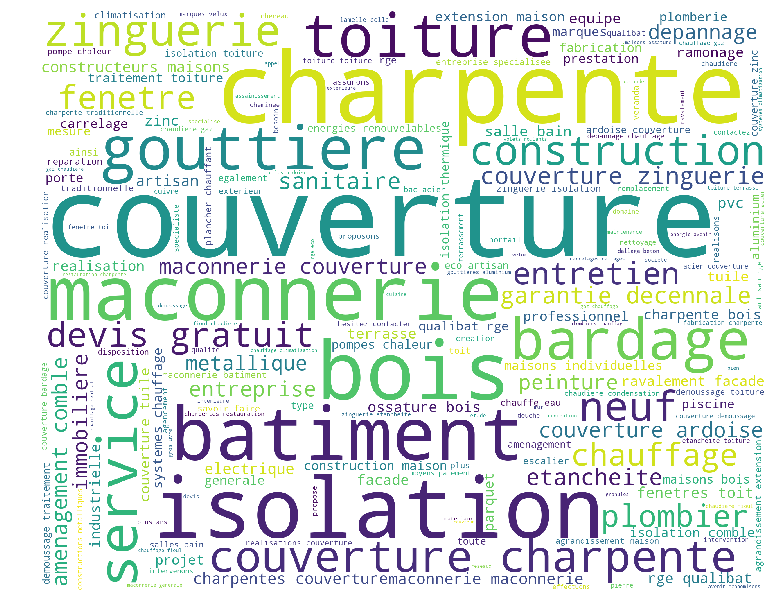

In [40]:
# On affiche le graphique avec les mots les plus prédominants dans la classe positive
print("Positive words")
wordcloud_draw(train_pos,'white')

**On remarque effectivement une prédominance du mot couverture dans la classe positive !!**

# Phase Apprentissage 

# Modélisation avec le mot couverture

**on cree une variable nommé couverture qui compte le nombre de fois que le mot 'couverture' apparait** 
**dans le corpus des documents :** <br>
-si le mot “couverture” est présent, alors la classe est positive<br>
-si le mot “couverture” est absent, alors la classe est négative<br>

In [77]:
couverture = data[data['description'].str.contains('couverture')][['description','class']]

In [78]:
# il y a 397 classes positives et (441-397 = 44) classes négatives
couverture['class'].describe(include = 'all')

count      441
unique       2
top       True
freq       397
Name: class, dtype: object

**Sachant que l'on a 958 classe positives !** 

In [79]:
# on cree le nouveau jeu de donnée pour la modélisation
dataset = train.copy()
dataset = dataset[['description','class']]

In [80]:
dataset['couverture'] = dataset['description'].str.count('couverture')

In [81]:
dataset

,description,class,couverture
0,fabricant porte portail aluminium porte entree...,False,0
1,cheminees accessoires specialiste fer forge de...,False,0
2,bricolage outillage reproduction cle robinette...,False,0
3,revetements sols murs entreprise peinture deco...,False,0
4,chauffage chauffage sanitaires couverture,True,1
5,rideaux voilages tissus ameublement stores int...,False,0
6,couverture couverture zinguerie tubage chemine...,True,4
7,chauffage,False,0
8,plombiers chauffage chauffage plomberie contra...,False,0
9,pompes funebres marbrerie fleuriste contrat pr...,False,0


In [82]:
# On supprime les documents
dataset = dataset.drop('description',axis=1)

In [83]:
dataset

,class,couverture
0,False,0
1,False,0
2,False,0
3,False,0
4,True,1
5,False,0
6,True,4
7,False,0
8,False,0
9,False,0


### Découpage des données : Apprentissage-Test

In [84]:
from sklearn.model_selection import train_test_split
classe = dataset['class']
dataset.drop(['class'], axis = 1, inplace = True)

In [87]:
X_train, X_test, classe_train, classe_test = train_test_split(dataset,classe, test_size=0.2, random_state=2019)

In [92]:
# Les modèles qu'on a choisit à partir de la variable 'couverture'
clfs = [
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    DecisionTreeClassifier(),
    ExtraTreeClassifier(),
    XGBClassifier(),
    LogisticRegression()
]

aucs = []
fprs = []
tprs = []
precisions = []
recalls = []
f1_scores = []

for clf in clfs:
    print(clf.__class__.__name__)
    clf.fit(X_train, classe_train)

    fpr, tpr, _ = roc_curve(classe_test, clf.predict_proba(X_test)[:, 1])    
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(auc(fpr, tpr))

    precision, recall, _ = precision_recall_curve(classe_test, clf.predict_proba(X_test)[:, 1])
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score(classe_test, clf.predict(X_test)))

RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
DecisionTreeClassifier
ExtraTreeClassifier
XGBClassifier
LogisticRegression


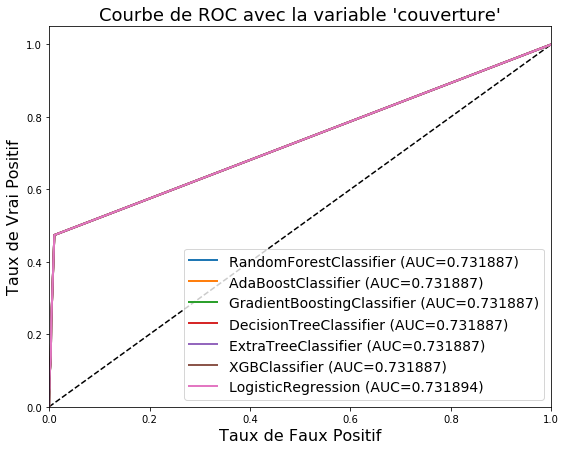

In [94]:
names = [clf.__class__.__name__ for clf in clfs]

plt.figure(figsize=(9, 7))
plt.plot([0, 1], [0, 1], 'k--')

for fpr3, tpr3, auc3, name in zip(fprs, tprs, aucs, names):
    plt.plot(fpr3, tpr3, label=name + ' (AUC=%.6f)' % auc3, lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positif', fontsize=16)
plt.ylabel('Taux de Vrai Positif', fontsize=16)
plt.title("Courbe de ROC avec la variable 'couverture'", fontsize=18)
plt.legend(loc="lower right", fontsize=14)

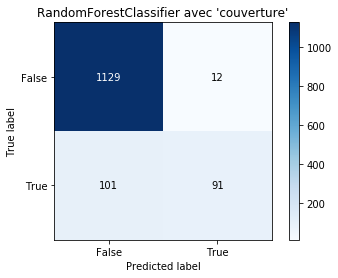

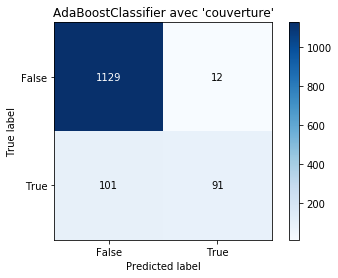

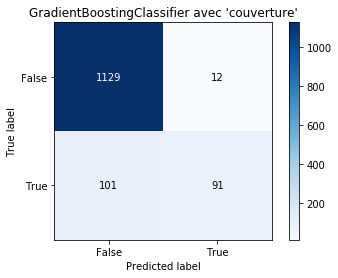

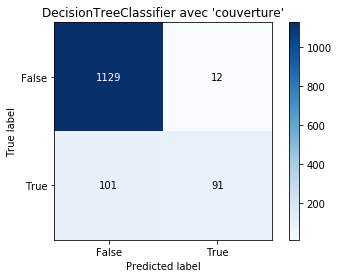

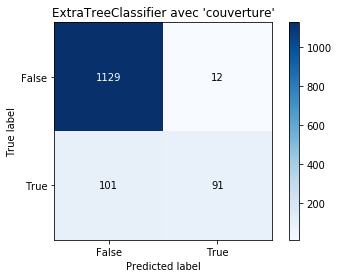

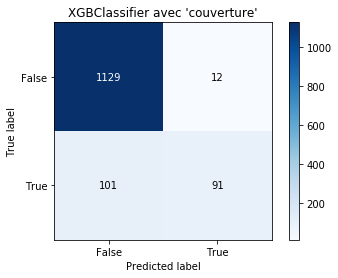

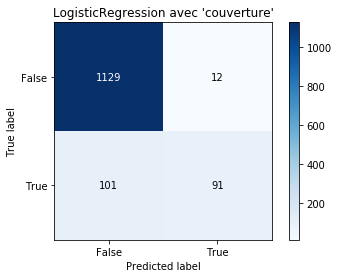

In [96]:
import scikitplot.plotters as skplt 
names = [clf.__class__.__name__ for clf in clfs]

for model,name in zip(clfs, names):
    model.fit(X_train, classe_train)
    skplt.plot_confusion_matrix(classe_test, model.predict(X_test), title = name + " avec 'couverture'")

# Bag Of Words

In [36]:
# Nous transformons la classe booléenne en variable indicatrice 0 pour Fasle et True pour 1 que l'on nomme target (variable cible)
from sklearn import preprocessing
lab_enc = preprocessing.LabelEncoder()
lab_enc.fit(train['class'])
variable = lab_enc.transform(train['class'])
train['target'] = variable
# train

# Phase d'Apprentissage avec plusieurs modèles

### Découpage des données : Apprentissage-Test

In [75]:
from sklearn.model_selection import train_test_split
dataset = train.copy()
classe = dataset['class']
dataset.drop(['class'], axis = 1, inplace = True)

In [76]:
phrase_train, phrase_test, classe_train, classe_test = train_test_split(dataset.description,classe, test_size=0.2, random_state=2019)

## Création de Features avec Bag_Of_Words

In [41]:
## Construction des Bag-Of-Words dans les phrases d'apprentissage
cv = CountVectorizer(stop_words=STOP,max_features=10000)
bag_of_words_train_features = cv.fit_transform(phrase_train)

## Construction des Bag-Of-Words dans les phrases de text 
bag_of_words_test_features = cv.transform(phrase_test)

# Nous transformons chaque mot des documents en features qui vont servir à entrainer et tester nos modèles

In [42]:
bag_of_words_train_features.shape

(5330, 7396)

In [43]:
bag_of_words_test_features.shape

(1333, 7396)

In [44]:
# Les modèles qu'on a choisit avec les features obtenus par la méthode Bag-Of-Word 
clfs = [
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    DecisionTreeClassifier(),
    ExtraTreeClassifier(),
    XGBClassifier(),
    LogisticRegression()
]

aucs = []
fprs = []
tprs = []
precisions = []
recalls = []
f1_scores = []

for clf in clfs:
    print(clf.__class__.__name__)
    clf.fit(bag_of_words_train_features, classe_train)

    fpr, tpr, _ = roc_curve(classe_test, clf.predict_proba(bag_of_words_test_features)[:, 1])    
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(auc(fpr, tpr))

    precision, recall, _ = precision_recall_curve(classe_test, clf.predict_proba(bag_of_words_test_features)[:, 1])
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score(classe_test, clf.predict(bag_of_words_test_features)))

RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
DecisionTreeClassifier
ExtraTreeClassifier
XGBClassifier
LogisticRegression


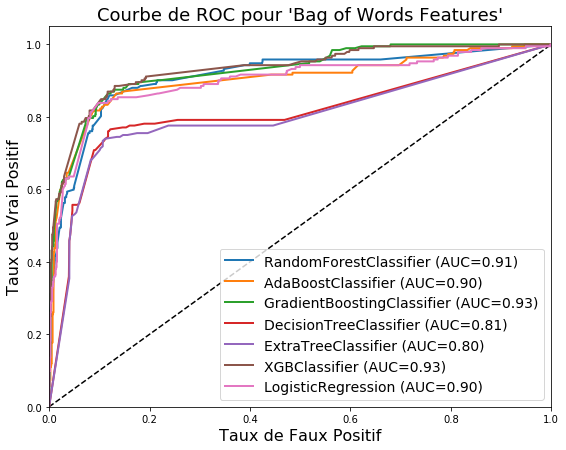

In [45]:
names = [clf.__class__.__name__ for clf in clfs]

plt.figure(figsize=(9, 7))
plt.plot([0, 1], [0, 1], 'k--')

for fpr1, tpr1, auc1, name in zip(fprs, tprs, aucs, names):
    plt.plot(fpr1, tpr1, label=name + ' (AUC=%.6f)' % auc1, lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positif', fontsize=16)
plt.ylabel('Taux de Vrai Positif', fontsize=16)
plt.title("Courbe de ROC pour 'Bag of Words Features'", fontsize=18)
plt.legend(loc="lower right", fontsize=14)

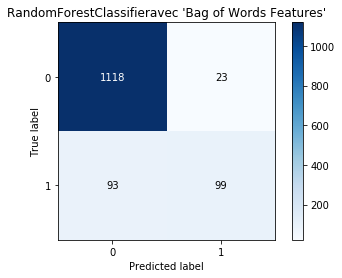

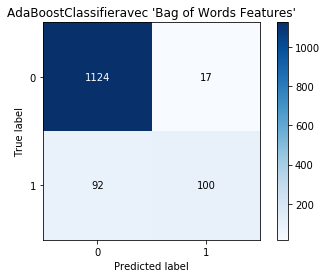

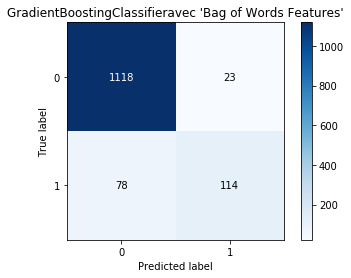

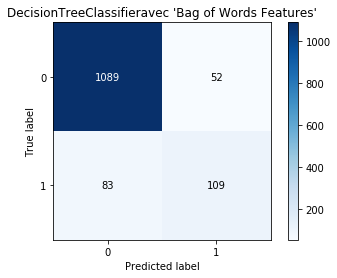

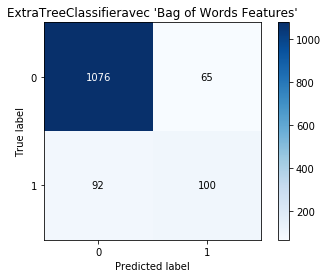

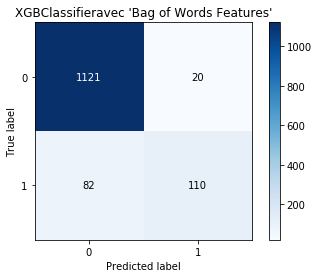

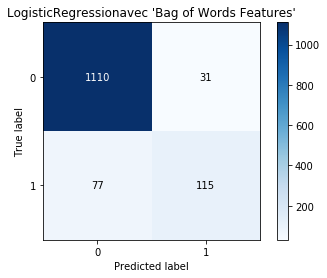

In [46]:
import scikitplot.plotters as skplt 
names = [clf.__class__.__name__ for clf in clfs]

for model,name in zip(clfs, names):
    model.fit(bag_of_words_train_features, classe_train)
    skplt.plot_confusion_matrix(classe_test, model.predict(bag_of_words_test_features), title = name + " avec 'Bag of Words Features'")

## Création de Features avec TF_IDF

In [47]:
## Construction des Features à partir de la méthode TF-IDF pour les données d'apprentissage
tv = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True)
tfidf_train_features = tv.fit_transform(phrase_train)

## Construction des Features à partir de la méthode TF-IDF pour les données de test
tfidf_test_features = tv.transform(phrase_test)

In [48]:
# All classifiers with default parameters for Bag-Of-Word features
clfs = [
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    DecisionTreeClassifier(),
    ExtraTreeClassifier(),
    XGBClassifier(),
    LogisticRegression()
]

aucs = []
fprs = []
tprs = []
precisions = []
recalls = []
f1_scores = []

for clf in clfs:
    print(clf.__class__.__name__)
    clf.fit(tfidf_train_features, classe_train)

    fpr, tpr, _ = roc_curve(classe_test, clf.predict_proba(tfidf_test_features)[:, 1])    
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(auc(fpr, tpr))

    precision, recall, _ = precision_recall_curve(classe_test, clf.predict_proba(tfidf_test_features)[:, 1])
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score(classe_test, clf.predict(tfidf_test_features)))

RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
DecisionTreeClassifier
ExtraTreeClassifier
XGBClassifier
LogisticRegression


### Courbe de ROC

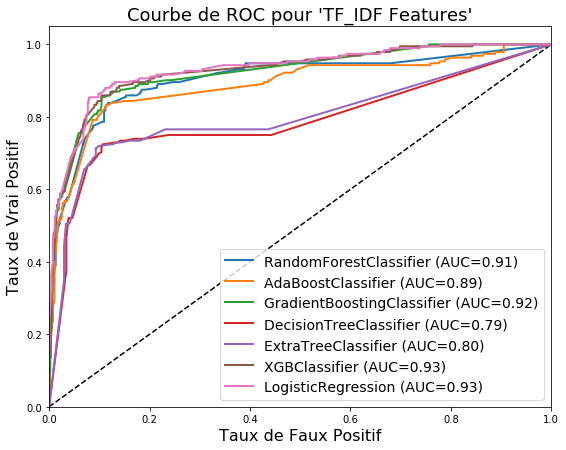

In [49]:
names = [clf.__class__.__name__ for clf in clfs]

plt.figure(figsize=(9, 7))
plt.plot([0, 1], [0, 1], 'k--')

for fpr2, tpr2, auc2, name in zip(fprs, tprs, aucs, names):
    plt.plot(fpr2, tpr2, label=name + ' (AUC=%.4f)' % auc2, lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positif', fontsize=16)
plt.ylabel('Taux de Vrai Positif', fontsize=16)
plt.title("Courbe de ROC pour 'TF_IDF Features'", fontsize=18)
plt.legend(loc="lower right", fontsize=14)

### Matrice de confusion

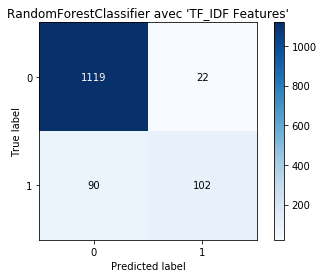

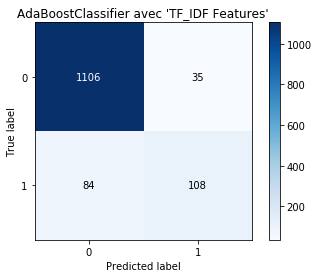

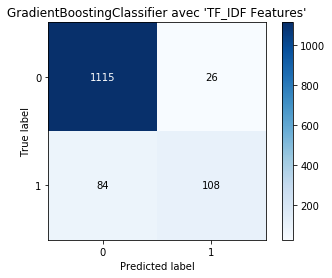

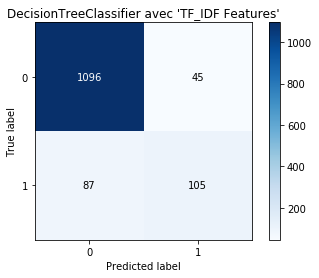

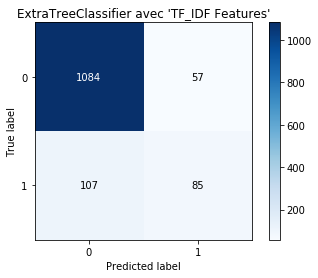

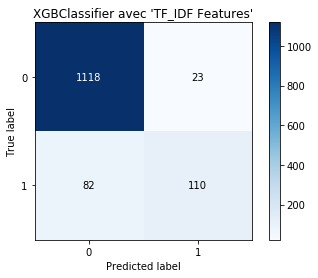

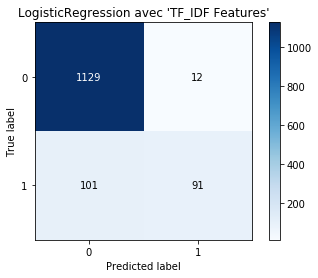

In [50]:
import scikitplot.plotters as skplt 
names = [clf.__class__.__name__ for clf in clfs]

for model,name in zip(clfs, names):
    model.fit(tfidf_train_features, classe_train)
    skplt.plot_confusion_matrix(classe_test, model.predict(tfidf_test_features), title = name + " avec 'TF_IDF Features'" )

## Création des Features avec Word2vec 

In [51]:
class Phrases(object):
    """MySentences est un générateur permettant de produire une liste de phrases tokenisées
    
     Prend une liste de tableaux numpy contenant des documents.
    
     Args:
         tableaux: liste des tableaux, où chaque élément du tableau contient un document.
     """
    def __init__(self, *arrays):
        self.arrays = arrays
 
    def __iter__(self):
        for array in self.arrays:
            for document in array:
                for sent in nltk.sent_tokenize(document):
                    yield nltk.word_tokenize(sent)

def Modele_word2vec(sentences, location):
    """Renvoie un modèle word2vec déjà entrainé sur d'autres dictionnaires par exemple !
    
     Argument d'entrée:
         phrases: itération de phrases (qu'on obtient en tokenizant le document avec la fonction précédente !)
        
         location (str): chemin d'accès pour sauvegarder / charger le modèle word2vec
     """
    if os.path.exists(location):
        print('Modèle trouvé {}'.format(location))
        model = gensim.models.Word2Vec.load(location)
        return model
    
    print('{} Aucun modèle trouvé. Entrainement du modèle'.format(location))
    model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)
    print('Modèle entrainé et sauvegardé sur le disque')
    model.save(location)
    return model

In [52]:
import os
import gensim

In [53]:
# Comme ici on a pas entrainé le modèle W2vec sur un dictionnaire au préalable on va l'entrainer
# sur les phrases du présent corpus pour ensuite nous générer les vecteurs associés à chaque mots
w2vec = get_word2vec(
    Phrases(
        phrase_train.values, 
        phrase_train.values  
    ),
    'w2vmodel'
)

Modèle trouvé w2vmodel


In [54]:
class Les_Tokens:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [55]:
class Moyenne_Des_Vecteurs(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # si un texte est vide, la classe doit retourner un vecteur rempli de zéros
         # avec la même dimensionnalité que tous les autres vecteurs
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = Les_Tokens().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [56]:
## Construction des Features à partir de la méthode Word2vec pour les données d'apprentissage
moyennes_des_vecteurs = Moyenne_Des_Vecteurs(w2vec)
Word2vec_train_features = moyennes_des_vecteurs.fit_transform(phrase_train)

## Construction des Features à partir de la méthode Word2vec pour les données d'apprentissage
Word2vec_test_features = moyennes_des_vecteurs.fit_transform(phrase_test)

In [57]:
Word2vec_train_features.shape

(5330, 100)

In [58]:
Word2vec_test_features.shape

(1333, 100)

In [59]:
# All classifiers with default parameters for Word2vec features
clfs = [
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    DecisionTreeClassifier(),
    ExtraTreeClassifier(),
    XGBClassifier(),
    LogisticRegression()
]

aucs = []
fprs = []
tprs = []
precisions = []
recalls = []
f1_scores = []

for clf in clfs:
    print(clf.__class__.__name__)
    clf.fit(Word2vec_train_features, classe_train)

    fpr, tpr, _ = roc_curve(classe_test, clf.predict_proba(Word2vec_test_features)[:, 1])    
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(auc(fpr, tpr))

    precision, recall, _ = precision_recall_curve(classe_test, clf.predict_proba(Word2vec_test_features)[:, 1])
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score(classe_test, clf.predict(Word2vec_test_features)))

RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
DecisionTreeClassifier
ExtraTreeClassifier
XGBClassifier
LogisticRegression


## Courbe de ROC

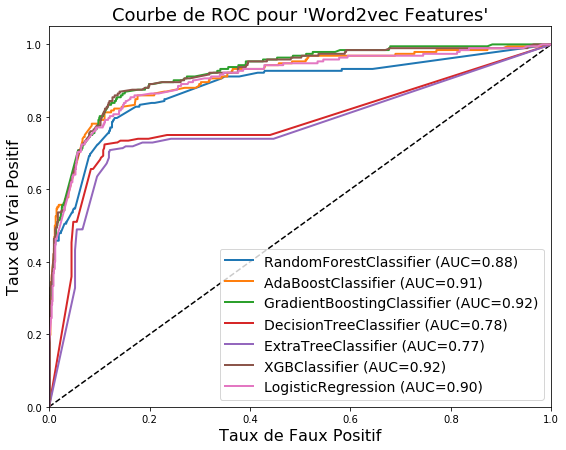

In [60]:
names = [clf.__class__.__name__ for clf in clfs]

plt.figure(figsize=(9, 7))
plt.plot([0, 1], [0, 1], 'k--')

for fpr2, tpr2, auc2, name in zip(fprs, tprs, aucs, names):
    plt.plot(fpr2, tpr2, label=name + ' (AUC=%.2f)' % auc2, lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positif', fontsize=16)
plt.ylabel('Taux de Vrai Positif', fontsize=16)
plt.title("Courbe de ROC pour 'Word2vec Features'", fontsize=18)
plt.legend(loc="lower right", fontsize=14)

## Matrice de confusion

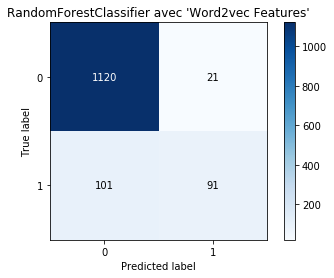

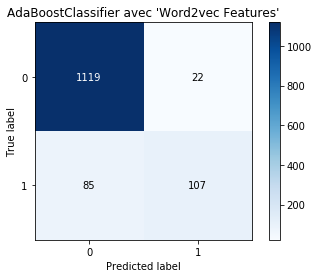

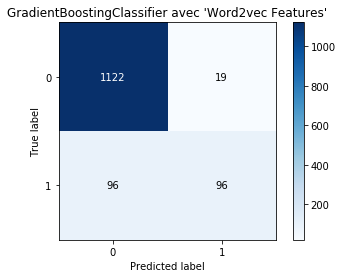

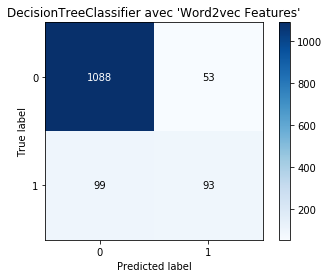

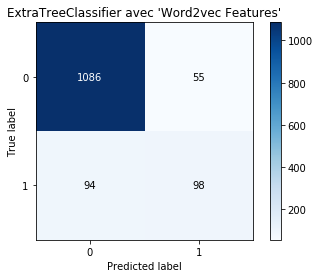

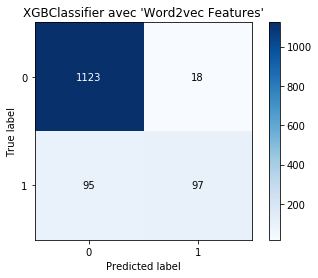

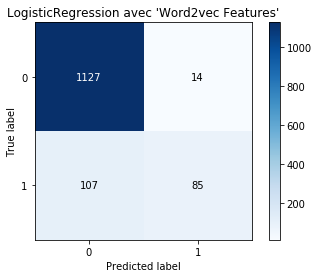

In [61]:
names = [clf.__class__.__name__ for clf in clfs]

for model,name in zip(clfs, names):
    model.fit(Word2vec_train_features, classe_train)
    skplt.plot_confusion_matrix(classe_test, model.predict(Word2vec_test_features), title = name + " avec 'Word2vec Features'" )

## LSTM 

In [62]:
# pip install keras
# pip install tensorflow

In [63]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam

Using TensorFlow backend.


In [73]:
# On utlise la fonction tokenizer de Keras
num_words = 2000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train.description.values)

In [74]:
# Pad the data 
X = tokenizer.texts_to_sequences(train.description.values)
X = pad_sequences(X, maxlen=2000)

In [78]:
# Construction du modèle LSTM en choisisant certains paramètres sans optimisation préalable par GridSearchCV
embed_dim = 128
lstm_out = 196

# Le modèle que l'on va sauvegarder après apprentissage 
ckpt_callback = ModelCheckpoint('lstm_model', 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')

model = Sequential()
model.add(Embedding(num_words, embed_dim, input_length = X.shape[1]))
model.add(LSTM(lstm_out, recurrent_dropout=0.2, dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['categorical_crossentropy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 2000, 128)         256000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


In [79]:
Y = pd.get_dummies(train['class']).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, stratify=Y)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(5330, 2000) (5330, 2)
(1333, 2000) (1333, 2)


## Courbe de ROC

In [80]:
batch_size = 32
model.fit(X_train, Y_train, epochs=8, batch_size=batch_size, validation_split=0.2, callbacks=[ckpt_callback])

Instructions for updating:
Use tf.cast instead.
Train on 4264 samples, validate on 1066 samples
Epoch 1/8
4264/4264 [==============================] - 1099s 258ms/step - loss: 0.3358 - categorical_crossentropy: 0.3358 - val_loss: 0.2599 - val_categorical_crossentropy: 0.2599

Epoch 00001: val_loss improved from inf to 0.25993, saving model to keras_model
Epoch 2/8
4264/4264 [==============================] - 738s 173ms/step - loss: 0.2200 - categorical_crossentropy: 0.2200 - val_loss: 0.2417 - val_categorical_crossentropy: 0.2417

Epoch 00002: val_loss improved from 0.25993 to 0.24171, saving model to keras_model
Epoch 3/8
4264/4264 [==============================] - 715s 168ms/step - loss: 0.2005 - categorical_crossentropy: 0.2005 - val_loss: 0.2489 - val_categorical_crossentropy: 0.2489

Epoch 00003: val_loss did not improve from 0.24171
Epoch 4/8
4264/4264 [==============================] - 718s 168ms/step - loss: 0.1908 - categorical_crossentropy: 0.1908 - val_loss: 0.3021 - val_ca

In [82]:
# On sauvegarde le modèle
model = load_model('keras_model')

In [83]:
LSTM = model

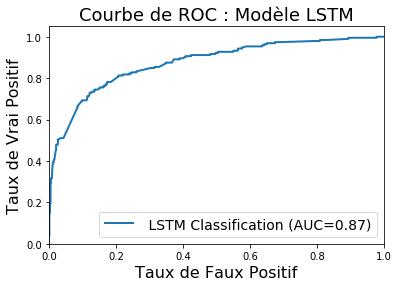

In [94]:
fpr, tpr, _ = roc_curve(Y_test[:, 1], LSTM.predict_proba(X_test)[:, 1])
aucs = auc(fpr, tpr)
plt.plot(fpr, tpr, label= ' LSTM Classification (AUC=%.2f)' % aucs, lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positif', fontsize=16)
plt.ylabel('Taux de Vrai Positif', fontsize=16)
plt.title("Courbe de ROC : Modèle LSTM", fontsize=18)
plt.legend(loc="lower right", fontsize=14)

## Matrice de confusion

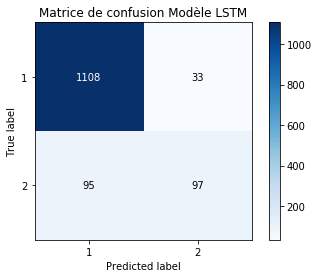

In [99]:
probas = LSTM.predict(X_test)
pred_indices = np.argmax(probas, axis=1)
classes = np.array(range(1, 10))
preds = classes[pred_indices]
skplt.plot_confusion_matrix(classes[np.argmax(Y_test, axis=1)], preds , title = "Matrice de confusion Modèle LSTM")

## Comparaison des résultats obtenus par les différentes méthodes

**Comparaison des AUC :** 
- XGboost et GradientBoosting performent (AUC = 0.93) bien avec la méthode Bag of Words
- XGboost et la Regression logistique performent mieux (AUC = 0.93) avec la méthode TF-IDF
- XGboost et GradientBoosting performent bien (AUC = 0.92) avec la méthode Word2Vec
- LSTM donne de moins bon résultat (AUC = 0.87) qu'avec les 3 méthodes précédentes

**Comparaison par la matrice de confusion**


In [ ]:
model1 = GradientBoostingClassifier()
model2 = XGBClassifier()
model3 = LogisticRegression()

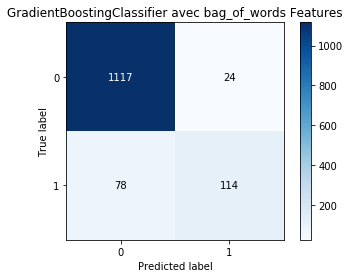

In [103]:
model1.fit(bag_of_words_train_features, classe_train)
skplt.plot_confusion_matrix(classe_test, model1.predict(bag_of_words_test_features), title = "Gradient Boosting avec bag_of_words Features" )

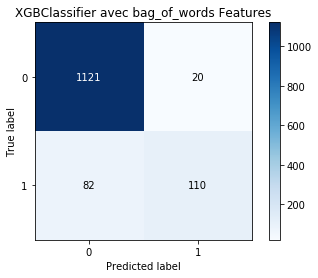

In [106]:
model2.fit(bag_of_words_train_features, classe_train)
skplt.plot_confusion_matrix(classe_test, model2.predict(bag_of_words_test_features), title =  "XGBoost avec bag_of_words Features" )

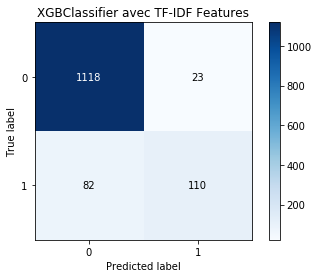

In [110]:
model2.fit(tfidf_train_features, classe_train)
skplt.plot_confusion_matrix(classe_test, model2.predict(tfidf_test_features), title =  "XGBoost avec TF-IDF Features" )

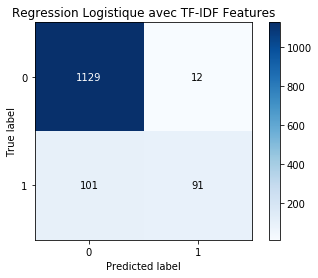

In [111]:
model3.fit(tfidf_train_features, classe_train)
skplt.plot_confusion_matrix(classe_test, model3.predict(tfidf_test_features), title =  "Regression Logistique avec TF-IDF Features" )

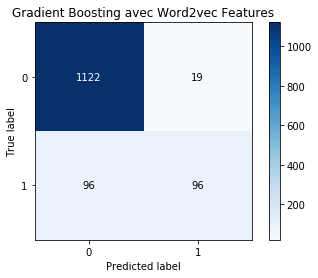

In [113]:
model1.fit(Word2vec_train_features, classe_train)
skplt.plot_confusion_matrix(classe_test, model1.predict(Word2vec_test_features), title ="Gradient Boosting avec Word2vec Features" )

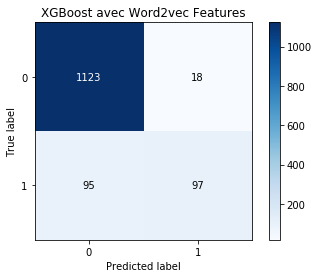

In [117]:
model2.fit(Word2vec_train_features, classe_train)
skplt.plot_confusion_matrix(classe_test, model2.predict(Word2vec_test_features), title ="XGBoost avec Word2vec Features" )

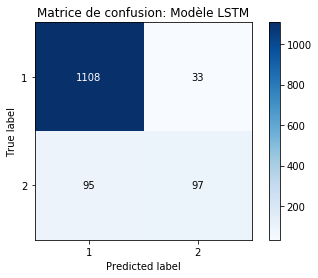

In [115]:
skplt.plot_confusion_matrix(classes[np.argmax(Y_test, axis=1)], preds , title = "Matrice de confusion: Modèle LSTM")

Comme à priori la classe est très déséquilibrée, le taux de faux positifs a tendance à être plus élévé :
On prefera donc choisir l'algorithme qui classifie au mieux classe 1 (positif)
- Pour la méthode Bag Of Word : on choisit le Gradient Boosting (Faux négatif = 78 et et Faux positif = 24)
- Pour la méthode TF-IDF : on choisit le XBBoost (Faux négatif = 82 et et Faux positif = 23)
- Pour la méthode Word2Vec : on choisit le XBBoost (Faux négatif = 95 et et Faux positif = 18 )
- LSTM donne de moins bons résultats que les 3 précédents algorithmes (Faux négatif = 95 et Faux positif = 33)

In [ ]:
col_names =  ['méthode', 'modèle', 'AUC','r2_train', 'r2_test']
results = pd.DataFrame(columns = col_names)
results

In [ ]:
xgboost_model = XGBRegressor(n_estimators=150,random_state= 0)
xgboost_model.fit(X_train,y_train)
rmse_train, rmse_test, r2_train, r2_test = evuluate(xgboost_model)
new_row = {'model name':"xgboost regressorr", 'rmse_train':rmse_train, 'rmse_test':rmse_test, 'r2_train':r2_train, 'r2_test':r2_test}
results = results.append(new_row, ignore_index=True)
print("{} train train rmse : {:.3f} test rmse : {:.3f} train r2 : {:.3f} test r2  : {:.3f}".format(new_row['model name'],new_row['rmse_train'], new_row['rmse_test'] ,new_row['r2_train'], new_row['r2_test']))

**Entre ces 3 algorithmes retenus : Il semble que le Gradient Boosting donne de meilleurs résultats avec la méthode classique
de Bag Of Word !**

## Recherche des paramètres optimaux

In [129]:
# On définit l'ensemble des valeurs que va prendre les hyperparamètres que l'on cherche à optimiser
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 50)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(3, 30, num = 3)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# On crée une liste de l'ensemble des paramètres à tunner
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               "criterion": ["friedman_mse",  "mae"]}

In [130]:
# Recherche des paramètres optimaux par la méthode RandomizedSearchCV (GridSearchCV)
tune_gb = RandomizedSearchCV(estimator = GradientBoostingClassifier(), param_distributions = random_grid, n_iter = 100, cv = 3, scoring = 'roc_auc', verbose=2, random_state = 167, n_jobs = -1)

In [ ]:
skplt.plot_confusion_matrix(classe_test, best.predict(bag_of_words_test_features), title = "Gradient Boosting optimisé avec bag_of_words Features" )

# Axes d'amélioration

 - **Axe d'amélioration : rééquilibrer la classe target**
 - **Utiliser la lemmetization plutot que la stemmetization pour voir si ca améliore les performances des modèles**
 - **Réduction de dimension propres aux données textuelles avec SVD (comme ACP pour les données numériques)**
 - **Doc2vec ou encore FastText  pour obtenir d'autre feature et tester**
